# Lymphoid_No5-RV_analysis-of-DEGs

In [9]:
outdir='/home/jovyan/projects/kk14_DCM-lymphoid/notebooks/final/figures/'

## Import required modules

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import gseapy as gp
from venn import venn

In [18]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
appdirs             1.4.4
backcall            0.2.0
bioservices         1.7.11
bs4                 4.9.3
certifi             2020.12.05
cffi                1.14.5
chardet             3.0.4
colorama            0.4.4
colorlog            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
easydev             0.11.0
get_version         2.1
google              NA
gseapy              0.10.4
h5py                2.10.0
idna                2.10
igraph              0.9.0
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.36.0
louvain             0.7.0
lxml                4.6.3
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.1
n

## Read in normalised lymphoid data

In [4]:
adata = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymphoid_annotated_scVI-UMAP_210513.h5ad')

# rename 'mutation negative' to 'PVneg'
adata.obs.replace({'Gene':{'mutation negative':'PVneg'}}, inplace=True)

# remove 'unclassified.1' and 'unclassified.2'
adata = adata[adata.obs['cell_states'].isin(['unclassified.1','unclassified.2'])==False]

print(adata.X.data[:10])
adata

[1.8285189 1.8285189 2.4379303 1.8285189 2.8138494 1.8285189 1.8285189
 1.8285189 1.8285189 1.8285189]


/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 16726 × 25134
    obs: 'Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_type', 'cell_states'
    var: 'gene_ids-DCM', 'feature_types-DCM', 'genome-DCM', 'gene_ids-Harvard-Nuclei-HCA', 'feature_types-Harvard-Nuclei-HCA', 'gene_ids-Sanger-Nuclei-HCA', 'feature_types-Sanger-Nuclei-HCA', 'gene_ids-Sanger-Cells-HCA', 'feature_types-Sanger-Cells-HCA', 'gene_ids-Sanger-CD45-HCA', 'feature_types-Sanger-CD45-HCA', 'n_counts'
    uns: 'Cells_Nuclei_colors', '_scvi', 'cell_states_20210305_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Read DEG csv files and subset lymphoid DEGs

In [5]:
DEG_df = pd.read_csv('/home/jovyan/projects/kk14_DCM-lymphoid/results/DEGs_df/210526/LYMPHOIDS_ALLGENOTYPES_EDGER_RV.csv', engine='python', error_bad_lines=False, index_col=0)

# make lymphocytes list
lymphocytes = list(adata.obs['cell_states'].cat.categories)

# select lymphocytes
DEG_df = DEG_df[DEG_df['cell_state'].isin(lymphocytes)]
DEG_df['cell_state'].value_counts()

CD4T_act      167690
CD8T_trans    167690
NK_CD16hi     167690
CD8T_em       134152
NK_CD56hi     134152
CD4T_naive    100614
CD8T_cytox    100614
CD8T_te        67076
Name: cell_state, dtype: int64

## Select significantly **up-regulated** DEGs

* FDR < 0.05
* logFC >= 1

In [8]:
DEG_df

,Gene,logFC,logCPM,F,PValue,FDR,low_expression,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
1,A1BG,9.263341e-01,6.948326,0.864469,0.352492,1.000000,NaN,NaN,0.004000,0.007722,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA
2,A1BG-AS1,2.998464e-01,7.146198,0.079737,0.999680,1.000000,F,0.000000,0.028211,0.034921,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA
3,A1CF,-8.203380e-17,6.734739,0.000000,1.000000,1.000000,NaN,NaN,0.000000,0.000000,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA
4,A2M,1.781676e+00,8.559676,6.821962,0.009005,0.681776,F,0.166358,0.073816,0.379279,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA
5,A2M-AS1,-3.865866e-01,7.441517,0.201001,0.653915,0.995896,F,0.001786,0.039857,0.117857,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039674,ZXDC,9.645917e-01,7.985753,1.179407,0.277478,0.823349,F,0.084416,0.092928,0.161366,RV,CELLSTATE,NK_CD16hi,Lymphoid,control_TTN
1039675,ZYG11A,-1.709552e-16,7.102405,0.000000,1.000000,1.000000,NaN,NaN,0.000000,0.000000,RV,CELLSTATE,NK_CD16hi,Lymphoid,control_TTN
1039676,ZYG11B,-5.075638e-01,7.571494,0.191919,0.661325,1.000000,F,0.000000,0.029266,0.021324,RV,CELLSTATE,NK_CD16hi,Lymphoid,control_TTN
1039677,ZYX,-1.622432e+00,7.179910,1.309406,0.252504,0.823349,F,0.084416,0.034722,0.000000,RV,CELLSTATE,NK_CD16hi,Lymphoid,control_TTN


In [6]:
# add mutation column for visualisation
# reorder cell_states categories for visualisation
DEG_df['mutation']=[x.replace('control_','') for x in DEG_df['comparison']]
DEG_df['mutation']=DEG_df['mutation'].astype('category')
DEG_df['mutation']=DEG_df['mutation'].cat.reorder_categories(['LMNA','TTN','RBM20','PKP2','PVneg'])
DEG_df['cell_state']=DEG_df['cell_state'].astype('category')
DEG_df['cell_state']=DEG_df['cell_state'].cat.reorder_categories(['CD4T_naive','CD4T_act','CD8T_cytox','CD8T_trans','CD8T_te','CD8T_em','NK_CD16hi','NK_CD56hi'])
DEG_df.head()

,Gene,logFC,logCPM,F,PValue,FDR,low_expression,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison,mutation
1,A1BG,9.263341e-01,6.948326,0.864469,0.352492,1.000000,NaN,NaN,0.004000,0.007722,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA,LMNA
2,A1BG-AS1,2.998464e-01,7.146198,0.079737,0.999680,1.000000,F,0.000000,0.028211,0.034921,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA,LMNA
3,A1CF,-8.203380e-17,6.734739,0.000000,1.000000,1.000000,NaN,NaN,0.000000,0.000000,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA,LMNA
4,A2M,1.781676e+00,8.559676,6.821962,0.009005,0.681776,F,0.166358,0.073816,0.379279,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA,LMNA
5,A2M-AS1,-3.865866e-01,7.441517,0.201001,0.653915,0.995896,F,0.001786,0.039857,0.117857,RV,CELLSTATE,CD4T_act,Lymphoid,control_LMNA,LMNA


In [7]:
DEG_df = DEG_df[(DEG_df['FDR']<0.05)&(DEG_df['logFC']>=1)]
DEG_df['cell_state'].value_counts()

CD4T_act      19
CD8T_trans     9
NK_CD56hi      8
CD4T_naive     6
CD8T_te        2
CD8T_em        2
CD8T_cytox     1
NK_CD16hi      1
Name: cell_state, dtype: int64

## Number of DEGs

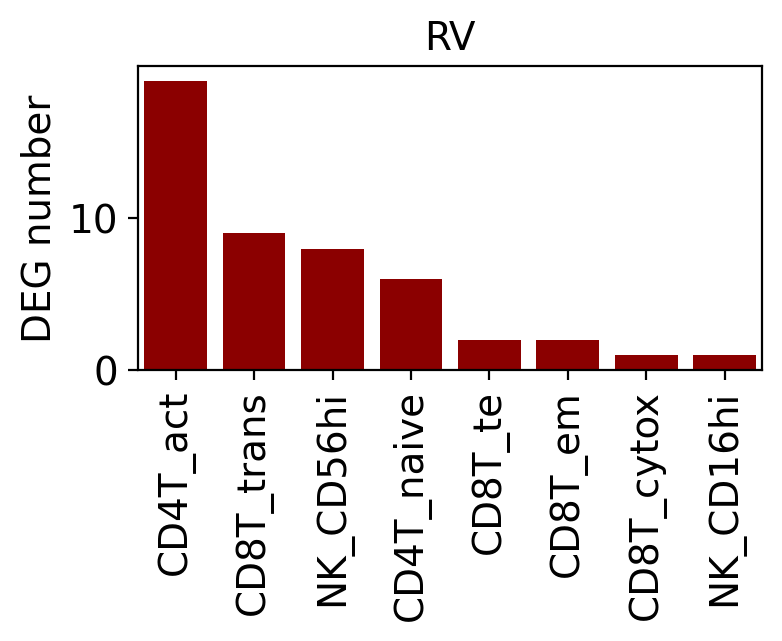

In [10]:
plt.figure(figsize=(4,2))
y = DEG_df['cell_state'].value_counts()
plt.bar(x=y.index, height=y, color='darkred')
plt.xticks(rotation=90)
plt.margins(x=0.01)
plt.grid(b=None)
plt.ylabel('DEG number')
plt.title('RV')
plt.savefig(outdir+'SupFig16D_nDEG_RV1.png', dpi=500, transparent=True, bbox_inches="tight")
plt.show()

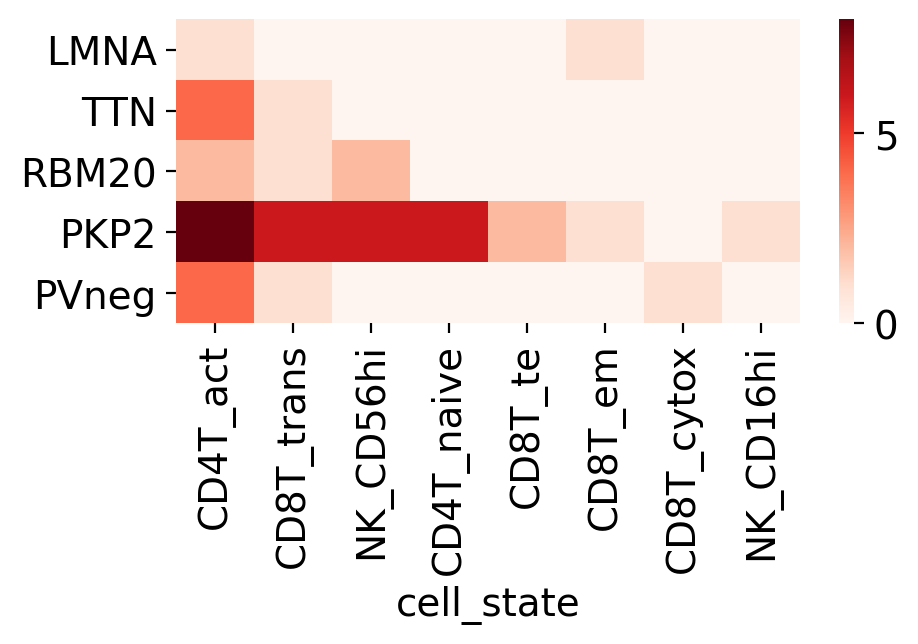

In [11]:
plt.figure(figsize=(5,2))
cross = pd.crosstab(DEG_df['cell_state'], DEG_df['mutation'])
cross = cross.reindex(DEG_df['cell_state'].value_counts().index)
sns.heatmap(cross.T, cmap='Reds')
plt.yticks(rotation=0)
plt.ylabel('')
plt.savefig(outdir+'SupFig16D_nDEG_RV2.png', dpi=500, transparent=True, bbox_inches="tight")
plt.show()

## Expression of DEGs in each cell state

-> CD4+T_act and CD8T_trans 

In [12]:
adata = adata[adata.obs['Gene'].isin(['control','LMNA','TTN','RBM20','PKP2','PVneg'])]
adata.obs['Gene'] = adata.obs['Gene'].astype('category')
adata.obs['Gene'] = adata.obs['Gene'].cat.reorder_categories(['control','LMNA','TTN','RBM20','PKP2','PVneg'])
adata.obs['Gene'].cat.categories

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Index(['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], dtype='object')

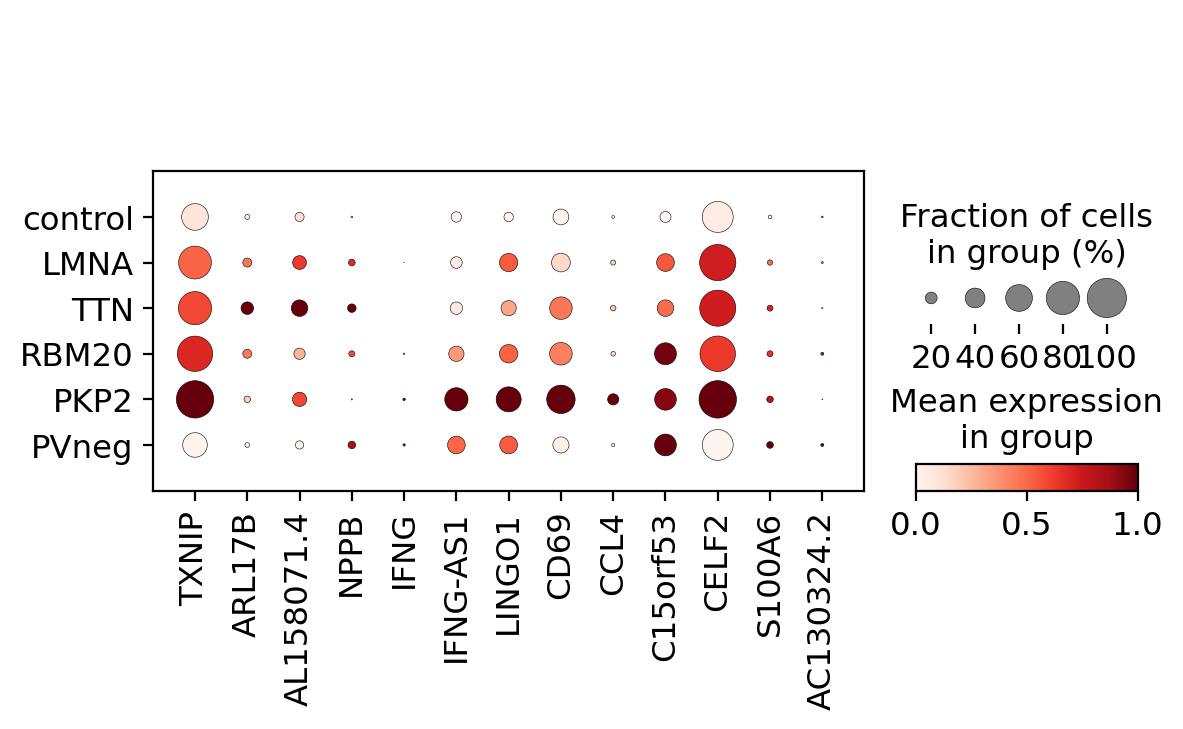

In [13]:
cell = 'CD4T_act'

DEG_list = list(DEG_df[(DEG_df['cell_state']==cell)].sort_values(by=['mutation'],ascending=True)['Gene'])
DEG_list = [DEG_list[i] for i in range(len(DEG_list)) if DEG_list[i] not in DEG_list[:i]]

sc.pl.dotplot(adata[adata.obs['cell_states']==cell],
              DEG_list, 
              groupby='Gene',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             )

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


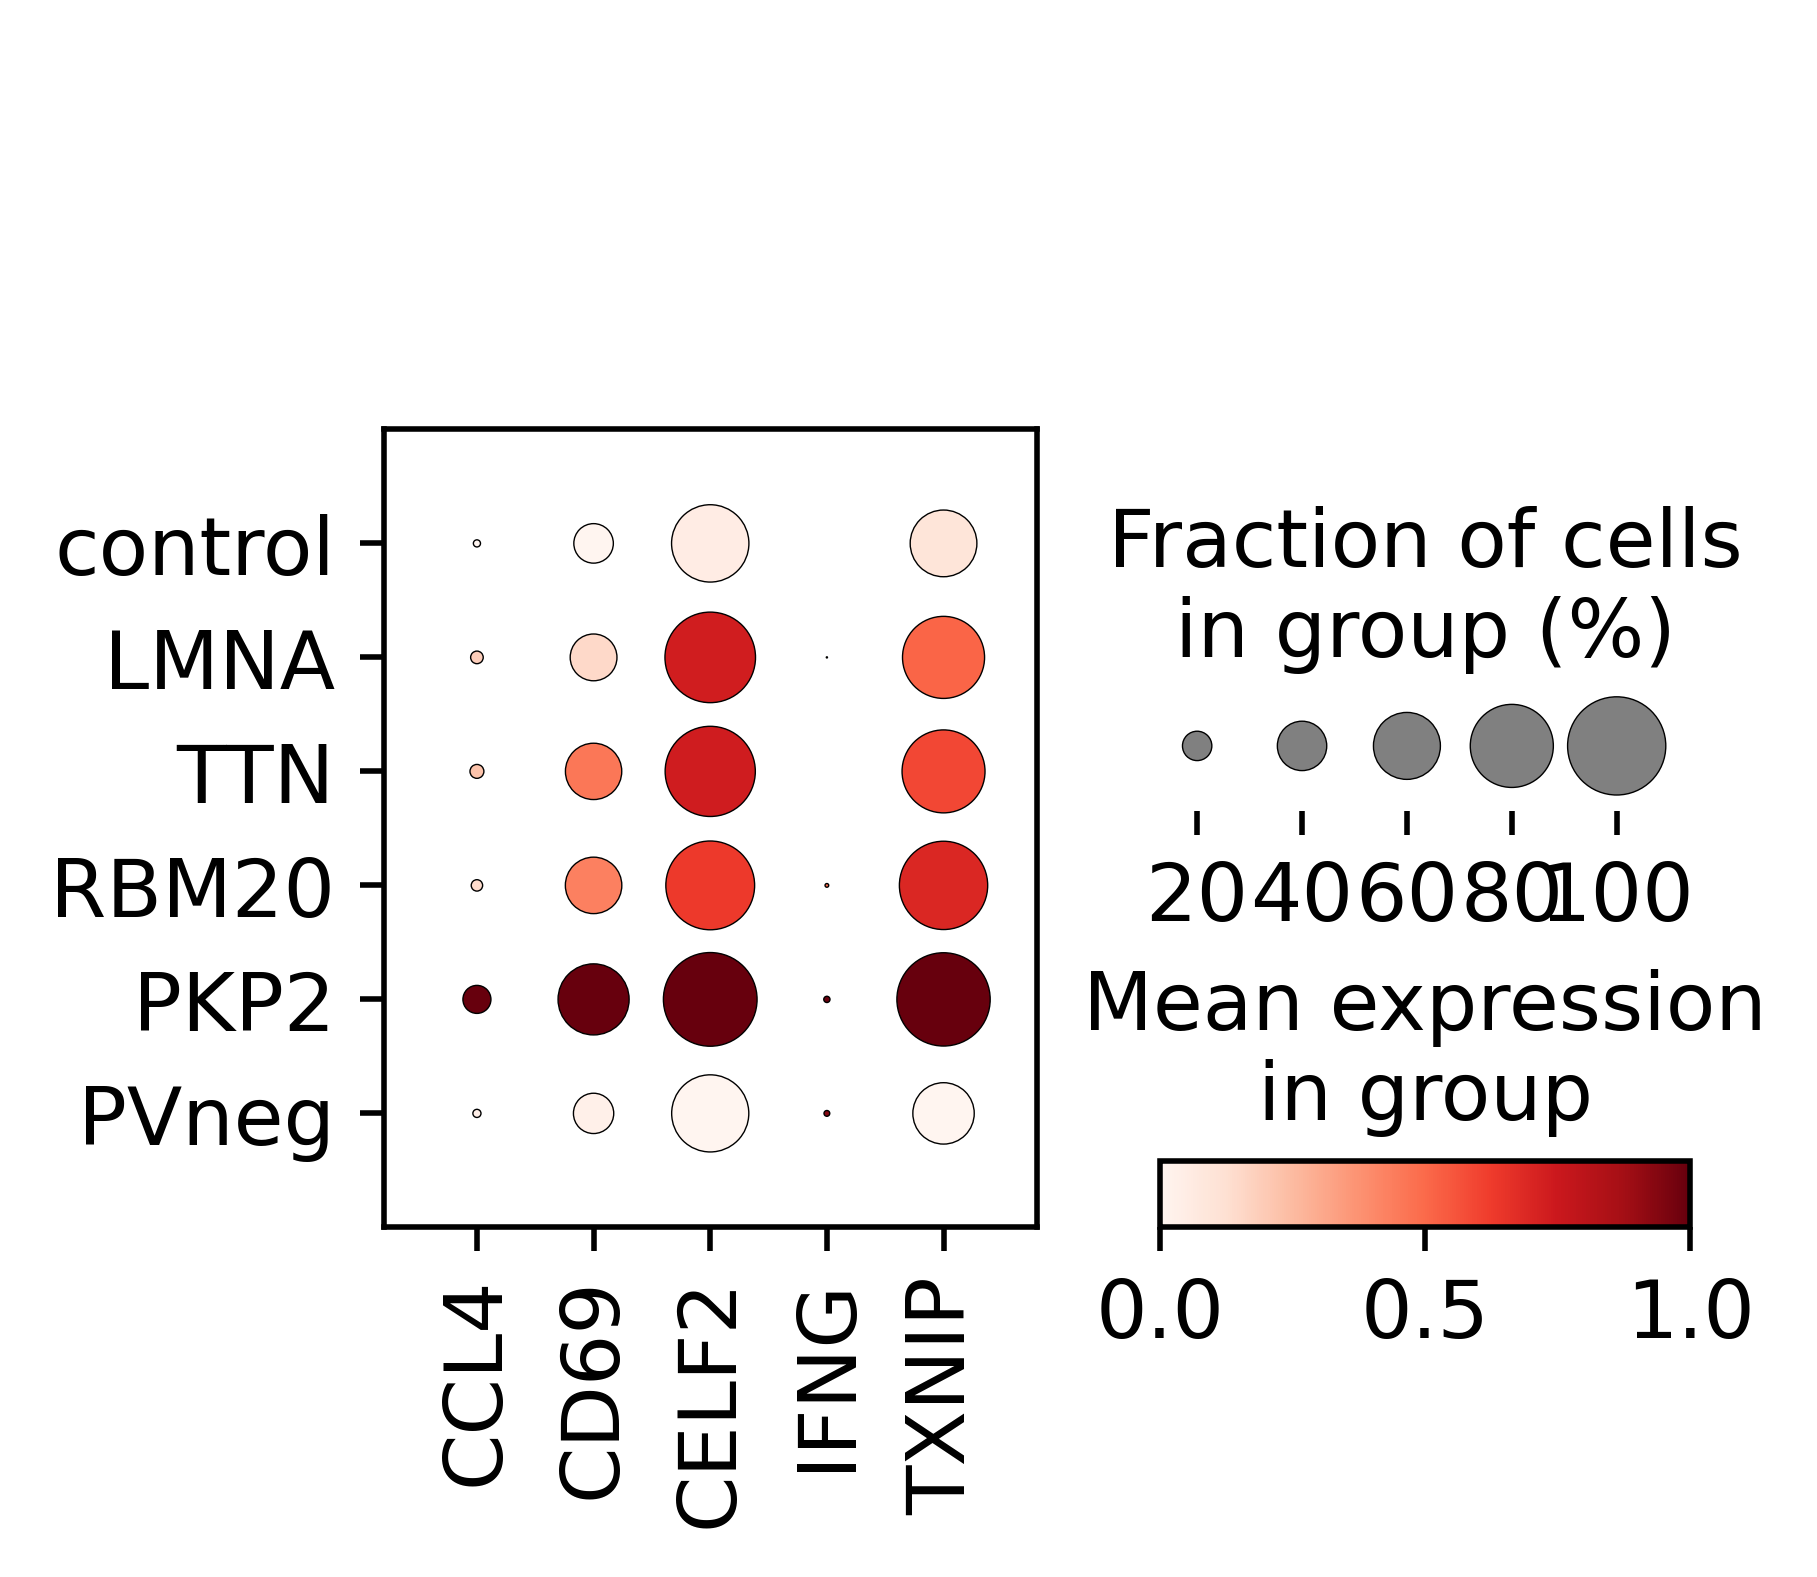

In [19]:
### selected genes ###
cell = 'CD4T_act'

genes = ['IFNG','CD69','TXNIP','CCL4','CELF2']
genes.sort()

sc.pl.dotplot(adata[adata.obs['cell_states']==cell],
              genes, 
              groupby='Gene',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              save='SupFig16E_DEGs_RV1.png'
             )

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


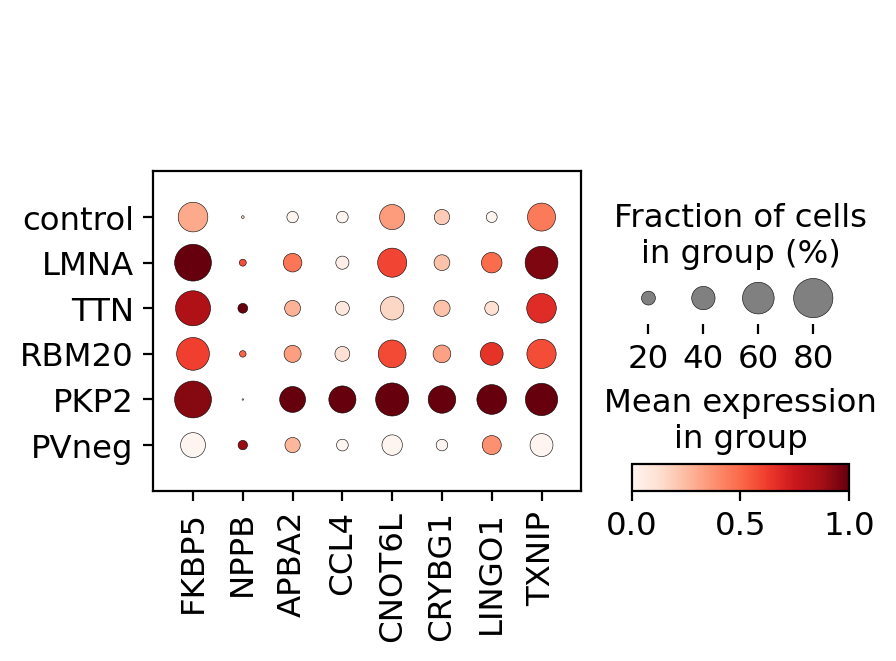

In [15]:
cell = 'CD8T_trans'

DEG_list = list(DEG_df[(DEG_df['cell_state']==cell)].sort_values(by=['mutation'],ascending=True)['Gene'])
DEG_list = [DEG_list[i] for i in range(len(DEG_list)) if DEG_list[i] not in DEG_list[:i]]

sc.pl.dotplot(adata[adata.obs['cell_states']==cell],
              DEG_list, 
              groupby='Gene',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             )

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


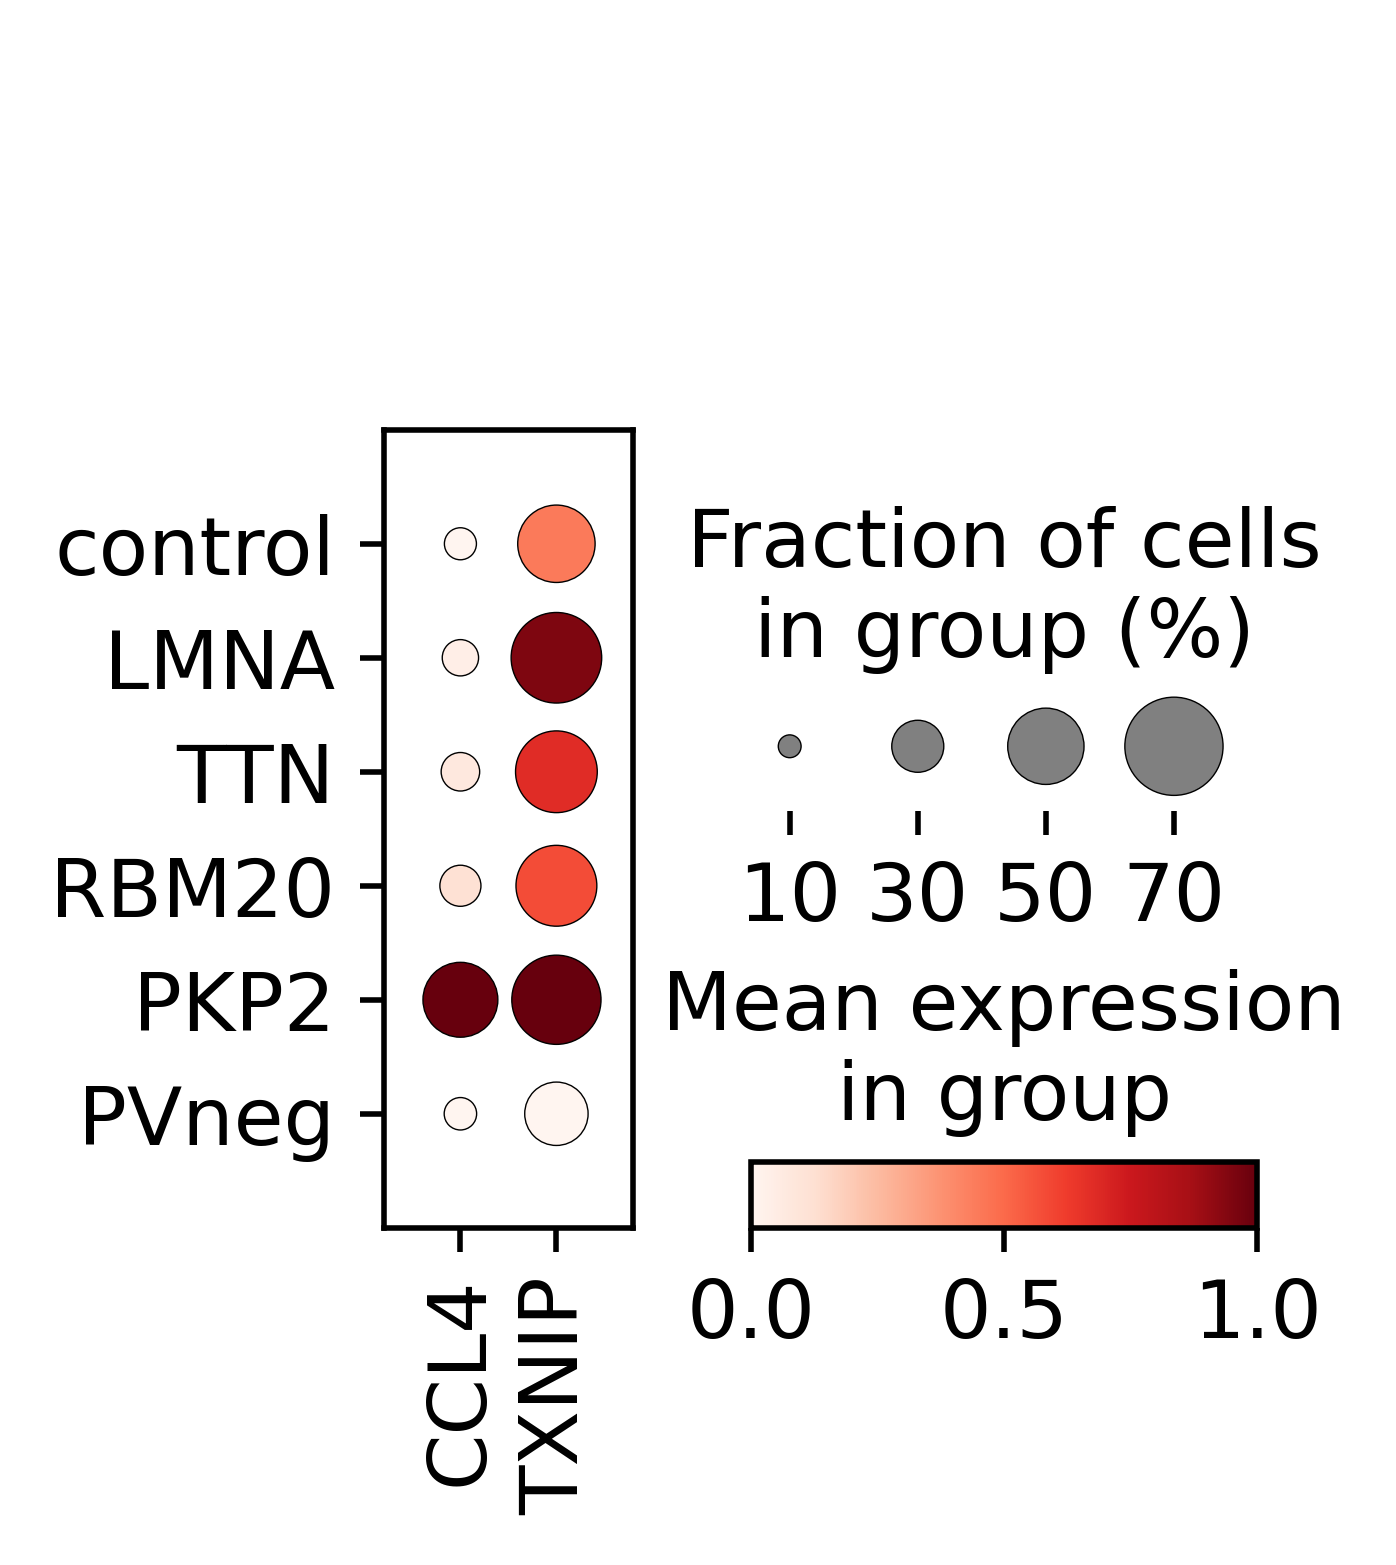

In [20]:
### selected genes ###
cell = 'CD8T_trans'

genes = ['TXNIP','CCL4']
genes.sort()

sc.pl.dotplot(adata[adata.obs['cell_states']==cell],
              genes, 
              groupby='Gene',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              save='SupFig16E_DEGs_RV2.png'
             )